Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 683 rows, 630 columns and 1870 nonzeros
Model fingerprint: 0xab0186b6
Variable types: 0 continuous, 630 integer (630 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+00]
Presolve removed 220 rows and 200 columns
Presolve time: 0.01s
Presolved: 463 rows, 430 columns, 1270 nonzeros
Variable types: 0 continuous, 430 integer (430 binary)
Found heuristic solution: objective 2291.5068270

Root relaxation: objective 1.993989e+03, 204 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    1993.9892905 1993.98929  0.00%     -    0s

Explored 1 nodes (20

<ipython-input-12-8ebaaf6a6490>:97: DeprecationWarning: Deprecated, pass a TempConstr or use Model.addLConstr
  contructConstrs()


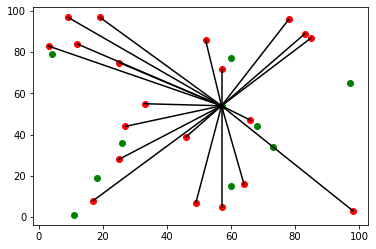

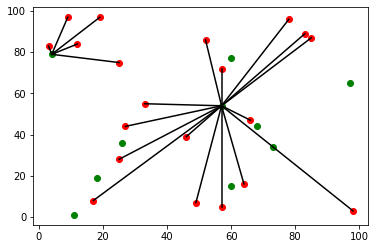

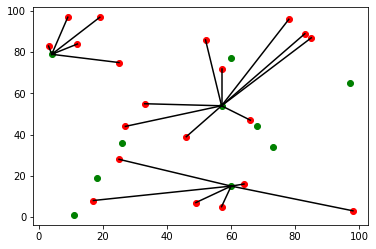

In [12]:
from gurobipy import * 
import numpy as np
import matplotlib.pyplot
import pandas as pd

def initializeData():
    fcs = pd.read_excel('data.xlsx', sheet_name='FCs').values.tolist()
    dps = pd.read_excel('data.xlsx', sheet_name='DPs').values.tolist()
    noFacilities = len(fcs)
    noDemandPoints = len(dps)
    distances = []
    for idx, i in enumerate(fcs):
        distances.append([])
        for j in dps:
            distances[idx].append(np.linalg.norm(np.array(i) - np.array(j)))
    timePeriods = [6, 5, 9]

    return ( fcs, dps, noFacilities, noDemandPoints, distances, timePeriods )

( fcs, dps, noFacilities, noDemandPoints, distances, timePeriods ) = initializeData()
# print(fcs)
noPeriods = len(timePeriods)

xVars = [ [ 0 for i in range( noFacilities ) ] for j in range( noPeriods ) ]
yVars = [ [ [ 0 for i in range( noDemandPoints ) ] for j in range( noFacilities ) ] for k in range( noPeriods ) ]

ipModel = Model( "project" ) 

def constructVars(): 
    global noFacilities , noDemandPoints , ipModel , xVars , yVars , noPeriods
    for k in range( noPeriods ):
        for i in range( noFacilities ): 
            var = ipModel.addVar( vtype = GRB.BINARY , name = "x_" + str( k + 1 ) + "_" + str( i + 1 ) ) 
            xVars[ k ][ i ] = var 

    for k in range( noPeriods ):
        for i in range( noFacilities ):
            for j in range( noDemandPoints ):
                var = ipModel.addVar( vtype = GRB.BINARY , name = "y_" + str( k + 1 ) + "_" + str( i + 1 ) + "_" + str( j + 1 ) )
                yVars[ k ][ i ][ j ] = var
    
    ipModel.update()

def constructObj(): 
    global noFacilities , noDemandPoints , distances , ipModel , yVars 
    objExpr = LinExpr() 
    for k in range( noPeriods ):
        objExprTemp = LinExpr()
        for i in range( noFacilities ): 
            for j in range( noDemandPoints ): 
                objExprTemp += distances[ i ][ j ] * yVars[ k ][ i ][ j ]
        objExpr += objExprTemp
    ipModel.setObjective( objExpr , GRB.MINIMIZE ) 
    ipModel.update() 

def contructConstrs(): 
    global yVars , ipModel , xVars , noDemandPoints , noFacilities , noPeriods

    for k in range( noPeriods ):
        for i in range( noFacilities ):
            constExprRhs = LinExpr()
            constExprRhs = 1.0 * xVars[ k ][ i ]
            for j in range( noDemandPoints ):
                constExprLhs = LinExpr()
                constExprLhs = 1.0 * yVars[ k ][ i ][ j ]
                ipModel.addConstr( lhs = constExprLhs , sense = GRB.LESS_EQUAL , rhs = constExprRhs )
    
    for k in range( noPeriods ):
        constExprLhs = LinExpr()
        constExprRhs = LinExpr()
        constExprRhs = 1.0 * ( k + 1 )
        for i in range( noFacilities ):
            constExprLhs += 1.0 * xVars[ k ][ i ]
        ipModel.addConstr( lhs = constExprLhs , sense = GRB.EQUAL , rhs = constExprRhs )

    constExprRhs = LinExpr()
    constExprRhs = 1.0
    for k in range( noPeriods ):
        for j in range( noDemandPoints ):
            constExprLhs = LinExpr()
            for i in range( noFacilities ):
                constExprLhs += yVars[ k ][ i ][ j ]
            ipModel.addConstr( lhs = constExprLhs , sense = GRB.EQUAL , rhs = constExprRhs )

    for k in range( 1, noPeriods ):
        for i in range( noFacilities ):
            constExprLhs = LinExpr()
            constExprRhs = LinExpr()
            constExprLhs = 1.0 * xVars[ k ][ i ]
            constExprRhs = 1.0 * xVars[ k - 1 ][ i ]
            ipModel.addConstr( lhs = constExprLhs , sense = GRB.GREATER_EQUAL , rhs = constExprRhs )

    ipModel.update()

constructVars() 
constructObj() 
contructConstrs() 
ipModel.write( "project.lp" ) 
ipModel.optimize() 
# ipModel.printAttr( "X" ) 

data = ipModel.getAttr( "X" )
assgns = [ [ 0 for i in range( noDemandPoints ) ] for j in range( noPeriods ) ]
yValues = data[noPeriods * noFacilities:]
yValues = np.reshape(yValues, (noPeriods, noFacilities, noDemandPoints))
for k in range( noPeriods ):
    for i in range( noFacilities ):
        for j in range( noDemandPoints ):
            if yValues[ k ][ i ][ j ] == 1.0:
                assgns[ k ][ j ] = i

for k in range( noPeriods ):
    for fc in range( noFacilities ):
        matplotlib.pyplot.plot( fcs[ fc ][ 0 ]  , fcs[ fc ][ 1 ] , 'ro' , color = "green" , lw = 9 )

    for dp in range( noDemandPoints ):
        matplotlib.pyplot.plot( dps[ dp ][ 0 ]  , dps[ dp ][ 1 ] , 'ro' , color = "red" , lw = 9 )

    for dp in range( noDemandPoints ):
        dpx = dps[ dp ][ 0 ]
        dpy = dps[ dp ][ 1 ]
        fcx = fcs[ assgns[ k ][ dp ] ][ 0 ]
        fcy = fcs[ assgns[ k ][ dp ] ][ 1 ]
        matplotlib.pyplot.plot( [ dpx , fcx ], [ dpy , fcy ]  , color = "black"  )

    matplotlib.pyplot.show()

In [13]:
print(fcs[3], fcs[9], fcs[0]) #coordinates of facilities we want to open

[57, 54] [4, 79] [60, 15]


In [20]:
obj = ipModel.ObjVal()

TypeError: 'float' object is not callable